In [1]:
run='20Mar2024_fetal_FFPE'

In [2]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl

import cell2location
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 0
/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument w

In [3]:
import gc
import torch

In [4]:
import os

## Functions

In [5]:
def read_and_qc(sample_name, path):
    r""" This function reads the data for one 10X spatial experiment into the anndata object.
    It also calculates QC metrics. Modify this function if required by your workflow.

    :param sample_name: Name of the sample
    :param path: path to data
    """

    adata = sc.read_visium(path + str(sample_name),
                           count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata.var_names_make_unique(join='-')
    
    adata.obs['sample'] = sample_name
    
    # rename genes to ENSEMBL
    adata.var['SYMBOL'] = adata.var_names
    adata.var_names = adata.var['gene_ids']
    adata.var_names.name = None

    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata.var['mt'] = [gene.startswith('MT-') for gene in adata.var['SYMBOL']]
    adata.obs['mt_frac'] = adata[:, adata.var['mt'].tolist()].X.sum(1).A.squeeze()/adata.obs['total_counts']

    # add sample name to obs names
    adata.obs["sample"] = [str(i) for i in adata.obs['sample']]
    adata.obs_names = adata.obs["sample"] \
                          + '_' + adata.obs_names
    adata.obs.index.name = 'spot_id'

    return adata

def select_slide(adata, s, s_col='sample'):
    r""" This function selects the data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial experiments
    :param s: name of selected experiment
    :param s_col: column in adata.obs listing experiment name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

## Read in metadata

In [6]:
meta=pd.read_csv('/nfs/team205/heart/anndata_objects/Foetal/metadata/HeartTeamSamples_Mappeddata_20230208_for-cell2loc.csv',
                index_col=0)
meta

,sangerID,combinedID,donor,donor_type,region,region_finest,age,gender,facility,cell_or_nuclei,modality,kit_10x,flushed,status,cell2loc-map_group
Publication,,,,,,,,,,,,,,,
Foetal,BHF_F_Hea13295830,na,Hst45,na,Heart,Heart,PCW-16w,na,Sanger,na,Visium-FFPE,Visium V5 Slide - FFPE v2 (CytAssist),na,Healthy,FFPE_16PCW
Foetal,BHF_F_Hea13295831,na,Hst45,na,Heart,Heart,PCW-16w,na,Sanger,na,Visium-FFPE,Visium V5 Slide - FFPE v2 (CytAssist),na,Healthy,FFPE_16PCW
Foetal,HCAHeartST10298114,na,C83,na,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy,7PCW
Foetal,HCAHeartST10298115,na,C83,na,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy,7PCW
Foetal,HCAHeartST10298116,na,C83,na,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy,7PCW
Foetal,HCAHeartST10298117,na,C83,na,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy,7PCW
Foetal,HCAHeartST10298118,na,C83,na,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy,7PCW_DA
Foetal,HCAHeartST10298119,na,C83,na,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy,7PCW_DA
Foetal,HCAHeartST10298120,na,C83,na,Heart,Heart,GA-9w4d,na,Sanger,na,Visium,Visium-v1,na,Healthy,7PCW


In [7]:
pd.crosstab(meta['donor'],meta['cell2loc-map_group'])

cell2loc-map_group,13PCW,20PCW,4PCW,5PCW,7PCW,7PCW_DA,FFPE_16PCW,T21_13PCW
donor,,,,,,,,
C104,0,0,1,0,0,0,0,0
C83,0,0,0,0,10,5,0,0
C92,0,0,0,2,0,0,0,0
Hst33,2,0,0,0,0,0,0,0
Hst41,0,3,0,0,0,0,0,0
Hst44,0,0,0,0,0,0,0,4
Hst45,0,0,0,0,0,0,2,0


In [8]:
# select slides
# Healthy FFPE
meta = meta[meta['cell2loc-map_group'].isin(['FFPE_16PCW'])]

sampleIDs = list(meta['sangerID'])
len(sampleIDs)

2

In [9]:
meta

,sangerID,combinedID,donor,donor_type,region,region_finest,age,gender,facility,cell_or_nuclei,modality,kit_10x,flushed,status,cell2loc-map_group
Publication,,,,,,,,,,,,,,,
Foetal,BHF_F_Hea13295830,na,Hst45,na,Heart,Heart,PCW-16w,na,Sanger,na,Visium-FFPE,Visium V5 Slide - FFPE v2 (CytAssist),na,Healthy,FFPE_16PCW
Foetal,BHF_F_Hea13295831,na,Hst45,na,Heart,Heart,PCW-16w,na,Sanger,na,Visium-FFPE,Visium V5 Slide - FFPE v2 (CytAssist),na,Healthy,FFPE_16PCW


## Data, parameters

In [10]:
import os
results_folder = os.path.join(os.getcwd(),"analysis/Visium/cell2location_results")

ref_run_name = f'{results_folder}/reference_signatures/{run}'
run_name = f'{results_folder}/cell2location_map/{run}'


In [11]:
visium_path='/nfs/team205/heart/mapped/spaceranger200/'

celltype_key='fine_grain_modified'

vis_subset_key='cell2loc-map_group'

Found these subsets ['FFPE_16PCW']
###### FFPE_16PCW ######
visium read in
FFPE_16PCW: ['BHF_F_Hea13295830', 'BHF_F_Hea13295831']


/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


plotting HE image...


TypeError: can't multiply sequence by non-int of type 'float'

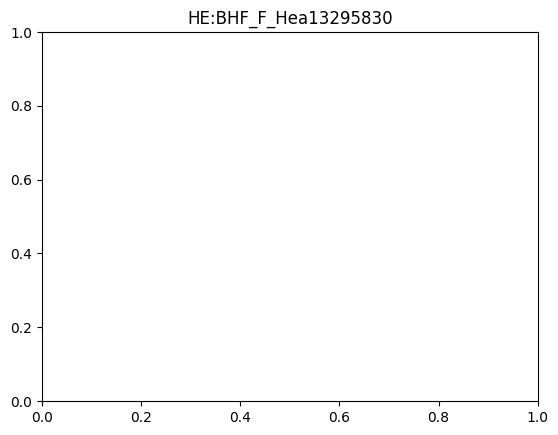

In [12]:
%%time
subset_values = os.listdir(os.path.join(results_folder, "cell2location_map", run))
print(f"Found these subsets {subset_values}")

for value in subset_values:
    print(f"###### {value} ######")
    adata_sub = sc.read(f"{run_name}/{value}/sp.h5ad")
    print("visium read in")
    adata_sub.obs[adata_sub.uns['mod']['factor_names']] = adata_sub.obsm['q05_cell_abundance_w_sf']
    IDs = meta[meta[vis_subset_key] == value].sangerID.tolist()
    print(f"{value}: {IDs}")

    for sample in IDs:
        try:
            slide = select_slide(adata_sub, sample)
        except IndexError as e:
            print(f"Sample {sample} not found in adata: {e}")
            continue  # Skip this sample if not found

        slide.obs[slide.uns['mod']['factor_names']] = slide.obsm['q05_cell_abundance_w_sf']
        list_of_cell_types = slide.uns['mod']['factor_names'].tolist()
        print("plotting HE image...")
        sc.pl.spatial(slide, color=None, size=0, img_key='hires', title=f"HE:{sample}", 
                      save=f"{run}__{value}__{sample}__HE.png", show=False)

        # Plotting abundances for all relevant cell states
        if list_of_cell_types:
            print("plotting abundances for all cell states...")
            sc.pl.spatial(slide, color=list_of_cell_types, cmap="RdPu", ncols=10, size=1.3, 
                          img_key='hires', vmin=0, vmax='p99.2', alpha_img=0.3, 
                          save=f"{run}__{value}__{sample}__all_cell_states_abundances.png", show=False)


In [13]:
%%time

adata_dict={}

subset_values = os.listdir(os.path.join(results_folder, "cell2location_map", run))
print(f"Found these subsets {subset_values}")

for value in subset_values:
    print(f"###### {value} ######")
    adata_sub = sc.read(f"{run_name}/{value}/sp.h5ad")
    print("visium read in")
    adata_sub.obs[adata_sub.uns['mod']['factor_names']] = adata_sub.obsm['q05_cell_abundance_w_sf']
    IDs = meta[meta[vis_subset_key] == value].sangerID.tolist()
    print(f"{value}: {IDs}")

    for sample in IDs:
        try:
            slide = select_slide(adata_sub, sample)
        except IndexError as e:
            print(f"Sample {sample} not found in adata: {e}")
            continue  # Skip this sample if not found

        slide.obs[slide.uns['mod']['factor_names']] = slide.obsm['q05_cell_abundance_w_sf']
        adata_dict[sample]=slide

Found these subsets ['FFPE_16PCW']
###### FFPE_16PCW ######
visium read in
FFPE_16PCW: ['BHF_F_Hea13295830', 'BHF_F_Hea13295831']


/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


CPU times: user 793 ms, sys: 1.66 s, total: 2.45 s
Wall time: 3.88 s


In [14]:
adata_dict.keys()

dict_keys(['BHF_F_Hea13295830', 'BHF_F_Hea13295831'])

In [21]:
from tqdm import tqdm
atrial_data_dict={}
for sample,tmp_adata in tqdm(adata_dict.items()):
    print(f"sample: {sample},  age is {tmp_adata.obs.age.unique().tolist()[0]}")
    tmp_df=tmp_adata[tmp_adata.obs.JC_edit=="Myocardium - Atrial"].obs[['AtrialCardiomyocytesLeft_immature', 'AtrialCardiomyocytesLeft', 'AtrialCardiomyocytesRight','AtrialCardiomyocytesRight_immature']]

    if tmp_df.shape[0]>0:
        tmp_df["sample"]=sample
        tmp_df["age"]=tmp_adata.obs.age.unique().tolist()[0]
        atrial_data_dict[sample]=tmp_df
    else:
        print(f"no atrial myocardium spots annotated for sample: {sample}")

  0%|                                                                                                                                                                                                                     | 0/2 [00:00<?, ?it/s]/tmp/ipykernel_266704/3397130741.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df["sample"]=sample
/tmp/ipykernel_266704/3397130741.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df["age"]=tmp_adata.obs.age.unique().tolist()[0]
/tmp/ipykernel_266704/339

sample: BHF_F_Hea13295830,  age is PCW-16w
sample: BHF_F_Hea13295831,  age is PCW-16w


In [22]:
data=pd.concat(list(atrial_data_dict.values()))
data

,AtrialCardiomyocytesLeft_immature,AtrialCardiomyocytesLeft,AtrialCardiomyocytesRight,AtrialCardiomyocytesRight_immature,sample,age
spot_id,,,,,,
BHF_F_Hea13295830_AACACTCGAAGTATCA-1,0.323285,11.070118,0.145178,0.011868,BHF_F_Hea13295830,PCW-16w
BHF_F_Hea13295830_AACAGCGATGCTTCAA-1,0.120990,1.176106,10.433854,0.067474,BHF_F_Hea13295830,PCW-16w
BHF_F_Hea13295830_AACAGGCCATCCGCGT-1,0.049149,1.147966,14.014021,0.003903,BHF_F_Hea13295830,PCW-16w
BHF_F_Hea13295830_AACAGTATCAACGCTT-1,0.110791,2.726954,12.570009,0.003329,BHF_F_Hea13295830,PCW-16w
BHF_F_Hea13295830_AACAGTCAATGTGATA-1,0.186758,17.203877,2.815982,0.009997,BHF_F_Hea13295830,PCW-16w
...,...,...,...,...,...,...
BHF_F_Hea13295831_TGTCGCGGCTACGCAC-1,0.159699,3.654230,21.926449,0.023600,BHF_F_Hea13295831,PCW-16w
BHF_F_Hea13295831_TGTCTGCCTCGTTAAG-1,0.076827,1.433332,24.742792,0.012840,BHF_F_Hea13295831,PCW-16w
BHF_F_Hea13295831_TGTTACAACGCTAATT-1,0.424777,15.822614,2.518111,0.019447,BHF_F_Hea13295831,PCW-16w


In [23]:
data.to_csv("AtrialProportionsFFPE.csv")

In [17]:
# Assuming 'data' is your pandas DataFrame
# Calculate the total for each row
total = data['AtrialCardiomyocytesImmature'] + data['AtrialCardiomyocytesRight'] + data['AtrialCardiomyocytesLeft']

# Calculate the proportions for each column
data['AtrialCardiomyocytesImmature_prop'] = data['AtrialCardiomyocytesImmature'] / total
data['AtrialCardiomyocytesRight_prop'] = data['AtrialCardiomyocytesRight'] / total
data['AtrialCardiomyocytesLeft_prop'] = data['AtrialCardiomyocytesLeft'] / total

# The new DataFrame 'data' now includes the proportion columns
data

NameError: name 'data' is not defined

In [19]:
import plotly.express as px
fig = px.scatter_ternary(data,
                         a="AtrialCardiomyocytesImmature_prop", b="AtrialCardiomyocytesLeft_prop", c="AtrialCardiomyocytesRight_prop",
                        color="age",
                        opacity=0.8)
fig.show()